#### aim: Make set of DIC pseudoobservations using a GLODAP ML product and various C_Anth (Anthropogenic C) estimates - for restarts and evaluation

Ideally we need by-year "pseudo-observational" DIC content files from 1880 to 2017

Here's the method:

1) Get a current (calling it year 2017) DIC content product (easy). 
    - In this case Keppler ML gridded product from here: https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0221526
    - This data contains observations made between 2004-2017. We will call it current for year 2011, I guess?
    - However it's only done for -64.5 lat to 64.5 lat, we need to make choices about what to do at the poles. 
2) Get an estimate of CAnth to date- actually to 2007 (a bit trickier):
    - combine CAnth to 1994 (Glodap 1.1, not well archived, taken from here: https://cdiac.ess-dive.lbl.gov/ftp/oceans/GLODAP_Gridded_Data/)
    - with dcant 1994-2007 Gruber/Carter (https://www.ncei.noaa.gov/data/oceans/ncei/ocads/metadata/0186034.html) 
3) using a scaling relationship suggested by Corinne, find the CAnth for all years from 1880 to 2022
    - this relationship is scaled based on the Canth at 2007 gotten in step 2.
4) if you then have the product from 1) DIC_year2011, you can get DIC_yearX as:
    - DIC_year2011-CAnt_year2011 + CAnt_yearX
5) you then need to interpolate onto the model grid
6) you then need to convert umol/kg to umol/L (everything above is umol/kg), probably using some density 
    
Steps 1-4 will be done on the classic WOA grid - 33 depths * 180 lat * 360 lon (* 2022-1948 years)
Then we have to regrid to ORCA2 grid. 

In [16]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [17]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## Download MOBO (Keppler) DIC product to ADA and visualize

only goes to 65 north, need to account and regrid to 180* 360

In [18]:
tdir = '/gpfs/home/mep22dku/scratch/SOZONE/Tuning/datasets/MOBO-DIC_MPIM_monthly_clim.nc'
w = xr.open_dataset(tdir)
tDIC = w['DIC'].values

tlat = np.arange(-89.5,90.5,1)
# len(tlat)
# print(np.where(tlat == -64.5))
# print(tlat[25])
DIC_fg = np.zeros([12,33,180,360])
DIC_fg[:,:,25:25+130:,:] = tDIC

Text(0.5, 1.0, 'MOBO contemporaryish DIC \n umol/kg, 2000m, january')

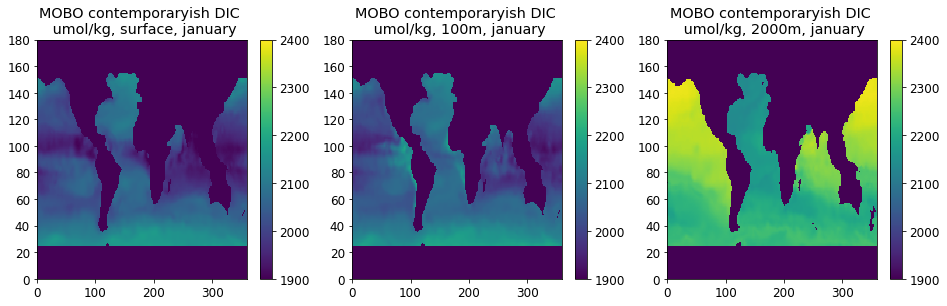

In [19]:
tmap = DIC_fg
tvmin = 1900
tvmax = 2400

fact = 0.4
fig, axs = plt.subplots(1,3, figsize=(40*fact, 11*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tw = axs[0].pcolormesh(tmap[0,0,:,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[0])
axs[0].set_title('MOBO contemporaryish DIC \n umol/kg, surface, january')

tw = axs[1].pcolormesh(tmap[0,6,:,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[1])
axs[1].set_title('MOBO contemporaryish DIC \n umol/kg, 100m, january')

tw = axs[2].pcolormesh(tmap[0,25,:,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[2])
axs[2].set_title('MOBO contemporaryish DIC \n umol/kg, 2000m, january')

## Look at Canth to 1994
Found on this random fileserver (multiple data access links broken...) https://cdiac.ess-dive.lbl.gov/ftp/oceans/GLODAP_Gridded_Data/

BC (Brendan Carter) says:
*I believe the 1994 Sabine et al. Canth values were gridded (and are provided) as part of the GLODAPv1 gridded product https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2004GB002247 (data available here as well, I believe). A caution that they had a gridding irregularity near the boundary between the Indian/Southern/Pacific Oceans, if I remember correctly.  In previous efforts I've erased that portion of the data and re-gridded it.*

This file represents anthropogenic DIC from preindustrial to 1994. We will also need Gruber et al deltaCanth file (see above)

(33, 180, 360)


Text(0.5, 1.0, 'Anth DIC to 1994, umol/kg, 2000m depth')

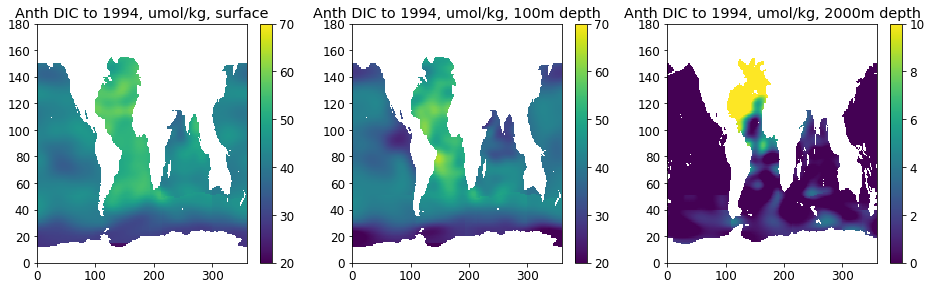

In [20]:
tdir = '/gpfs/home/mep22dku/scratch/SOZONE/Tuning/datasets/AnthCO2'
w = xr.open_dataset(f'{tdir}/AnthCO2.nc')
ACO2_1994 = w['AnthCO2'].values
ACO2_1994 = np.swapaxes(ACO2_1994, 1, 2)
print(np.shape(ACO2_1994))

tmap = ACO2_1994
tvmin = 20
tvmax = 70

fact = 0.4
fig, axs = plt.subplots(1,3, figsize=(40*fact, 11*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tw = axs[0].pcolormesh(tmap[0,:,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[0])
axs[0].set_title('Anth DIC to 1994, umol/kg, surface')

tw = axs[1].pcolormesh(tmap[6,:,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[1])
axs[1].set_title('Anth DIC to 1994, umol/kg, 100m depth')

tw = axs[2].pcolormesh(tmap[25,:,:], vmin = 0, vmax = 10)
plt.colorbar(tw, ax = axs[2])
axs[2].set_title('Anth DIC to 1994, umol/kg, 2000m depth')

## BC (Brendan Carter) mentioned a gridding weirdness in the anth DIC somewhere around the southern ocean, let's look

some slight weirdnesses but seems fine

(33, 180, 360)


Text(0.5, 1.0, 'Anth DIC to 1994, umol/kg, 2000m depth')

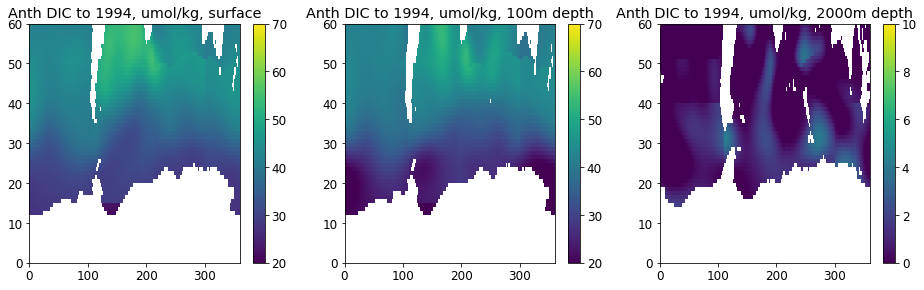

In [21]:
tdir = '/gpfs/home/mep22dku/scratch/SOZONE/Tuning/datasets/AnthCO2'
w = xr.open_dataset(f'{tdir}/AnthCO2.nc')
ACO2_1994 = w['AnthCO2'].values
ACO2_1994 = np.swapaxes(ACO2_1994, 1, 2)
print(np.shape(ACO2_1994))

tmap = ACO2_1994
tvmin = 20
tvmax = 70

fact = 0.4
fig, axs = plt.subplots(1,3, figsize=(40*fact, 11*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tw = axs[0].pcolormesh(tmap[0,0:60,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[0])
axs[0].set_title('Anth DIC to 1994, umol/kg, surface')

tw = axs[1].pcolormesh(tmap[6,0:60,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[1])
axs[1].set_title('Anth DIC to 1994, umol/kg, 100m depth')

tw = axs[2].pcolormesh(tmap[25,0:60,:], vmin = 0, vmax = 10)
plt.colorbar(tw, ax = axs[2])
axs[2].set_title('Anth DIC to 1994, umol/kg, 2000m depth')

## gruber, carter best estimate of increase in Canth 1994-2007

gridding irregularities in SO potentially

In [22]:
tdir = '/gpfs/home/mep22dku/scratch/SOZONE/Tuning/datasets/'
w2 = xr.open_dataset(f'{tdir}/dcant_emlr_cstar_gruber_94-07_vs1.nc')
ACO2_1994_2007 = w2['DCANT_01'].values
ACO2_2007 = ACO2_1994 + ACO2_1994_2007

Text(0.5, 1.0, 'DAnth DIC 1994-2007 \n umol/kg, 2000m depth')

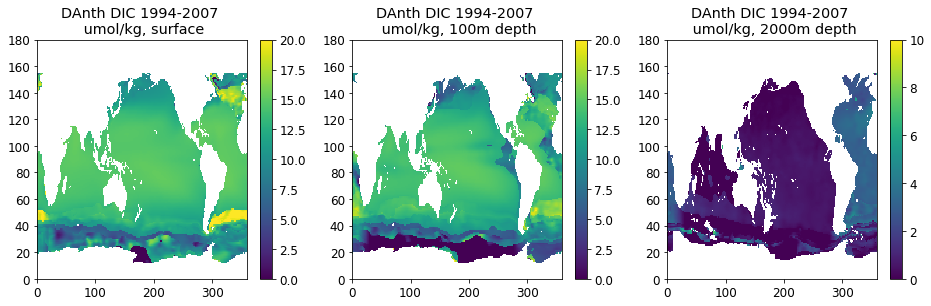

In [23]:
tmap = ACO2_1994_2007
tvmin = 0
tvmax = 20

fact = 0.4
fig, axs = plt.subplots(1,3, figsize=(40*fact, 11*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tw = axs[0].pcolormesh(tmap[0,:,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[0])
axs[0].set_title('DAnth DIC 1994-2007 \n umol/kg, surface')

tw = axs[1].pcolormesh(tmap[6,:,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[1])
axs[1].set_title('DAnth DIC 1994-2007 \n umol/kg, 100m depth')

tw = axs[2].pcolormesh(tmap[25,:,:], vmin = 0, vmax = 10)
plt.colorbar(tw, ax = axs[2])
axs[2].set_title('DAnth DIC 1994-2007 \n umol/kg, 2000m depth')

Text(0.5, 1.0, 'Anth DIC to 1994, umol/kg, 2000m depth')

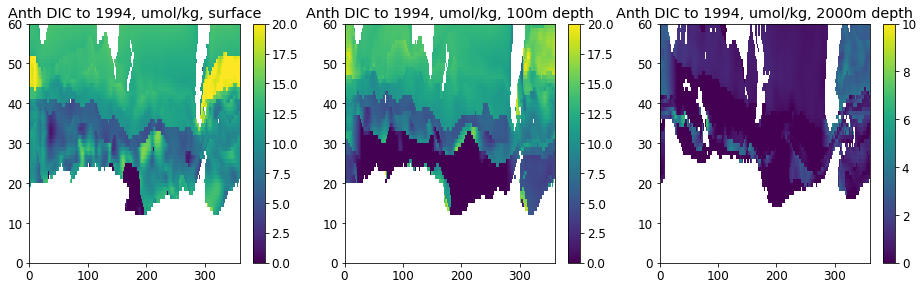

In [24]:
tmap = ACO2_1994_2007
tvmin = 0
tvmax = 20

fact = 0.4
fig, axs = plt.subplots(1,3, figsize=(40*fact, 11*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tw = axs[0].pcolormesh(tmap[0,0:60,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[0])
axs[0].set_title('Anth DIC to 1994, umol/kg, surface')

tw = axs[1].pcolormesh(tmap[6,0:60,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[1])
axs[1].set_title('Anth DIC to 1994, umol/kg, 100m depth')

tw = axs[2].pcolormesh(tmap[25,0:60,:], vmin = 0, vmax = 10)
plt.colorbar(tw, ax = axs[2])
axs[2].set_title('Anth DIC to 1994, umol/kg, 2000m depth')

Text(0.5, 1.0, 'Total Canth 2007 (Gruber Delta + Sabine Canth)   \n umol/kg, 2000m depth')

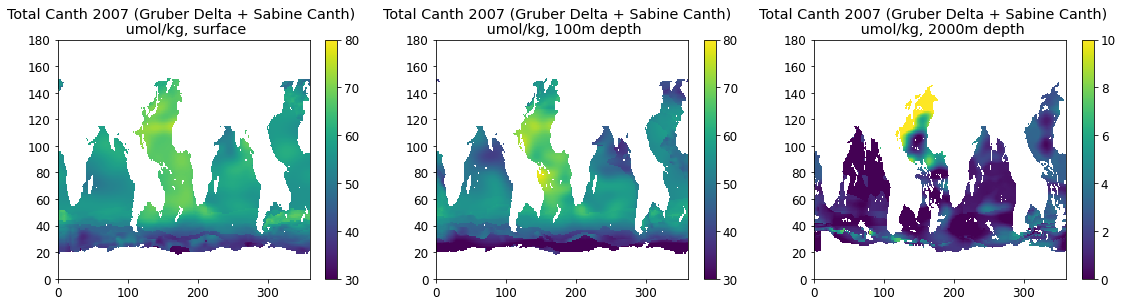

In [25]:
tmap = ACO2_2007
tvmin = 30
tvmax = 80

fact = 0.4
fig, axs = plt.subplots(1,3, figsize=(48*fact, 11*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tw = axs[0].pcolormesh(tmap[0,:,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[0])
axs[0].set_title('Total Canth 2007 (Gruber Delta + Sabine Canth) \n umol/kg, surface')

tw = axs[1].pcolormesh(tmap[6,:,:], vmin = tvmin, vmax = tvmax)
plt.colorbar(tw, ax = axs[1])
axs[1].set_title('Total Canth 2007 (Gruber Delta + Sabine Canth)  \n umol/kg, 100m depth')

tw = axs[2].pcolormesh(tmap[25,:,:], vmin = 0, vmax = 10)
plt.colorbar(tw, ax = axs[2])
axs[2].set_title('Total Canth 2007 (Gruber Delta + Sabine Canth)   \n umol/kg, 2000m depth')

# Canth scaling, corinne's notes

    DIC_yr = DIC_glodap - DICant*(1-alpha)
    alpha = (atmco2(glodap)-atmco2(t))/atmco2(glodap)
    
We have DICant for 2007
DICant for 2011 will be LARGER

Find DICant_yr:

DICant_yr = DICant_(2007) * (1-(atmco2(2007)-atmco2(yr))/atmco2(2007)



## atmospheric co2

- The yearly obs won't do what we need because they start at 1980 https://gml.noaa.gov/ccgg/trends/global.html
- grab meinshausen, should be same as atmos.co2.variable from UKESM model run forcing, get yearly means

atm co2 (uatm) at 2007: 382


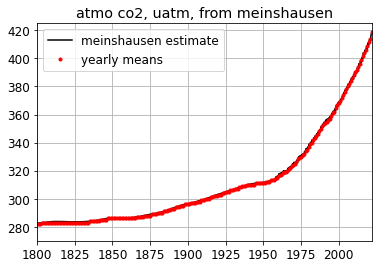

In [34]:
co2 = pd.read_csv('/gpfs/home/mep22dku/scratch/SOZONE/Tuning/datasets/ssp1-2.6-Table1.csv')
co2
yr = co2['1650.042'].values
co2atm = co2['276.58'].values

yrmns = np.arange(1800,2023,1)
yrmn_co2 = np.arange(1800,2023,1)

for i in range(1800,2023):
    yrmn_co2[i-1800] = np.nanmean(co2atm[(yr >= i) & (yr< i+1)])
    
plt.figure()
plt.plot(yr,co2atm, 'k-', label = 'meinshausen estimate')
plt.plot(yrmns,yrmn_co2, 'r.', label = 'yearly means')
plt.legend()
plt.xlim([1800,2022])
plt.ylim([270,425])
plt.grid()
plt.title('atmo co2, uatm, from meinshausen')
print(f'atm co2 (uatm) at 2007: {yrmn_co2[yrmns == 2007][0]}')


In [35]:
yrmn_co2[0]

282

## The scaling factor

red (as written by corinne) = [change in anthropogenic co2 between year-of-interest and year-2007(reference)] / [anthro co2 at year-2007(reference)]

I think it is more accurate to scale as (change between the two atm co2 measuements) / (change between reference measurement and preindustrial) (Shown in black)

That way alpha just represents the proportion of the change in anthropogenic atmospheric co2 from 1800-2007, since we didn't start at 0. using black line alpha

In [36]:
yrmns

array([1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810,
       1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821,
       1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832,
       1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843,
       1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854,
       1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865,
       1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876,
       1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887,
       1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898,
       1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909,
       1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920,
       1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1943, 1944, 1945, 1946, 1947, 1948, 1949, 19

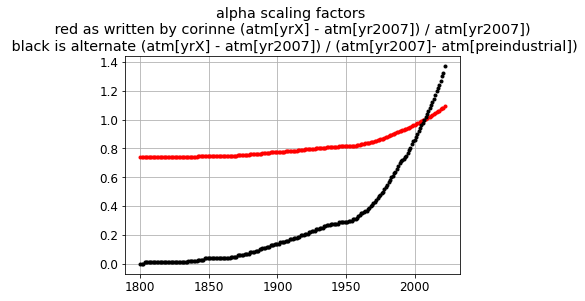

In [43]:
alpha = np.arange(1800,2023,1).astype('float')
alpha2 = np.arange(1800,2023,1).astype('float')

for i in range(1800,2023):
    alpha[i-1800] =  (1-(yrmn_co2[yrmns == 2007]-yrmn_co2[yrmns == i])/yrmn_co2[yrmns == 2007])
    alpha2[i-1800] =  (1-(yrmn_co2[yrmns == 2007]-yrmn_co2[yrmns == i])/(yrmn_co2[yrmns == 2007]-282))
plt.figure()
plt.plot(yrmns,alpha, 'r.', label = 'yearly means')
plt.plot(yrmns,alpha2, 'k.', label = 'yearly means')
plt.grid()
q = plt.title('alpha scaling factors \n red as written by corinne (atm[yrX] - atm[yr2007]) / atm[yr2007]) \n black is alternate (atm[yrX] - atm[yr2007]) / (atm[yr2007]- atm[preindustrial])')

get anthropogenic DIC for years 1800-2018

In [46]:
horse = False
if horse:

    refyrs = np.arange(1800,2023,1).astype('float')
    long = w2['LONGITUDE'].values
    lat = w2['LATITUDE'].values
    dep = w2['DEPTH'].values

    for i in range(0,len(refyrs)):
        ty = int(refyrs[i])
        talpha = alpha2[i]
        Anth_DIC = np.zeros([33,180,360])
        Anth_DIC= talpha * ACO2_2007
        Anth_DIC[ACO2_2007 == 0] = np.nan
        print(ty)
        # print(talpha)
        # print(np.nanmax(Anth_DIC))
        data_vars = {'Anth_DIC':(['depth', 'lat', 'lon'], Anth_DIC,
                                 {'units': 'µmol/kg',
                                  'long_name':'anthropogenic DIC'})           
                    }

        # define coordinates
        coords = {'depth': (['depth'], dep),\
                 'lat': (['lat'], lat),\
                 'lon': (['lon'], long)}

        # define global attributes
        attrs = {'made in':'Tuning/ML-GLODAPPseudoObsForRestart.ipynb',
                }   

        ds = xr.Dataset(data_vars=data_vars,
                        coords=coords,
                        attrs=attrs)

        fn = f'./WOA_AnthDIC/AnthDIC_{ty}.nc'
        ds.to_netcdf(fn)

next -

get anthropogenic DIC from 1940 to 2017
get PI DIC and get DIC estimates for all years PI to present day
look at gridding weirdness
regrid?


In [48]:
np.nan - 3

nan

#### get preindustrial C

In [49]:
### get preindustrial 
AnthDIC_2011 = xr.open_dataset('./WOA_AnthDIC/AnthDIC_2011.nc')
A2011vals = AnthDIC_2011['Anth_DIC'].values
A2011vals[A2011vals == 0] = np.nan
DIC_PI = np.zeros_like(DIC_fg)
DIC_fg[DIC_fg == 0] = np.nan
for m in range(0,12):
    DIC_PI[m,:,:,:] = DIC_fg[m,:,:,:] - A2011vals[:]
    
data_vars = {'Reconstructed_DIC':(['month','depth', 'lat', 'lon'], DIC_PI,
                         {'units': 'µmol/kg',
                          'long_name':'reconstructed DIC'})           
            }

# define coordinates
coords = {'month': (['month'], np.arange(1,13,1)),\
         'depth': (['depth'], dep),\
         'lat': (['lat'], lat),\
         'lon': (['lon'], long)}

# define global attributes
attrs = {'made in':'Tuning/ML-GLODAPPseudoObsForRestart.ipynb',
        }   

ds = xr.Dataset(data_vars=data_vars,
                coords=coords,
                attrs=attrs)

fn = f'./WOA_AnthDIC/EstimatedDIC_PI_1800.nc'
ds.to_netcdf(fn)

#### get C for all years, 1801 to 2017


In [51]:
horse = True
if horse:
    PI_DIC = xr.open_dataset('./WOA_AnthDIC/EstimatedDIC_PI_1800.nc')
    PI_DICvals = PI_DIC['Reconstructed_DIC'].values

    for y in range(1800,2023):
        #print(y)
        anth_DIC = xr.open_dataset(f'./WOA_AnthDIC/AnthDIC_{y}.nc')
        anth_DICvals = anth_DIC['Anth_DIC'].values
        #print(np.nanmax(anth_DICvals))
        DIC_thisyear = np.zeros_like(DIC_fg)
        for m in range(0,12):
            DIC_thisyear[m,:,:,:] = PI_DICvals[m,:,:,:] + anth_DICvals[:]

        data_vars = {'Reconstructed_DIC':(['month','depth', 'lat', 'lon'], DIC_thisyear,
                                 {'units': 'µmol/kg',
                                  'long_name':'reconstructed DIC'})           
                    }

        # define coordinates
        coords = {'month': (['month'], np.arange(1,13,1)),\
                 'depth': (['depth'], dep),\
                 'lat': (['lat'], lat),\
                 'lon': (['lon'], long)}

        # define global attributes
        attrs = {'made in':'Tuning/ML-GLODAPPseudoObsForRestart.ipynb',
                }   

        ds = xr.Dataset(data_vars=data_vars,
                        coords=coords,
                        attrs=attrs)

        fn = f'./WOA_AnthDIC/EstimatedDIC_{y}.nc'
        print(fn)
        ds.to_netcdf(fn)

./WOA_AnthDIC/EstimatedDIC_1800.nc
./WOA_AnthDIC/EstimatedDIC_1801.nc
./WOA_AnthDIC/EstimatedDIC_1802.nc
./WOA_AnthDIC/EstimatedDIC_1803.nc
./WOA_AnthDIC/EstimatedDIC_1804.nc
./WOA_AnthDIC/EstimatedDIC_1805.nc
./WOA_AnthDIC/EstimatedDIC_1806.nc
./WOA_AnthDIC/EstimatedDIC_1807.nc
./WOA_AnthDIC/EstimatedDIC_1808.nc
./WOA_AnthDIC/EstimatedDIC_1809.nc
./WOA_AnthDIC/EstimatedDIC_1810.nc
./WOA_AnthDIC/EstimatedDIC_1811.nc
./WOA_AnthDIC/EstimatedDIC_1812.nc
./WOA_AnthDIC/EstimatedDIC_1813.nc
./WOA_AnthDIC/EstimatedDIC_1814.nc
./WOA_AnthDIC/EstimatedDIC_1815.nc
./WOA_AnthDIC/EstimatedDIC_1816.nc
./WOA_AnthDIC/EstimatedDIC_1817.nc
./WOA_AnthDIC/EstimatedDIC_1818.nc
./WOA_AnthDIC/EstimatedDIC_1819.nc
./WOA_AnthDIC/EstimatedDIC_1820.nc
./WOA_AnthDIC/EstimatedDIC_1821.nc
./WOA_AnthDIC/EstimatedDIC_1822.nc
./WOA_AnthDIC/EstimatedDIC_1823.nc
./WOA_AnthDIC/EstimatedDIC_1824.nc
./WOA_AnthDIC/EstimatedDIC_1825.nc
./WOA_AnthDIC/EstimatedDIC_1826.nc
./WOA_AnthDIC/EstimatedDIC_1827.nc
./WOA_AnthDIC/Estima

## TAKEHOME PLOT: look at estimated DIC and increases, as maps and (non-weighted, oversimplified) depth profiles

first order look at DIC reconstructed with this method checks out with intuition, but need to make choices about what to do in the SO

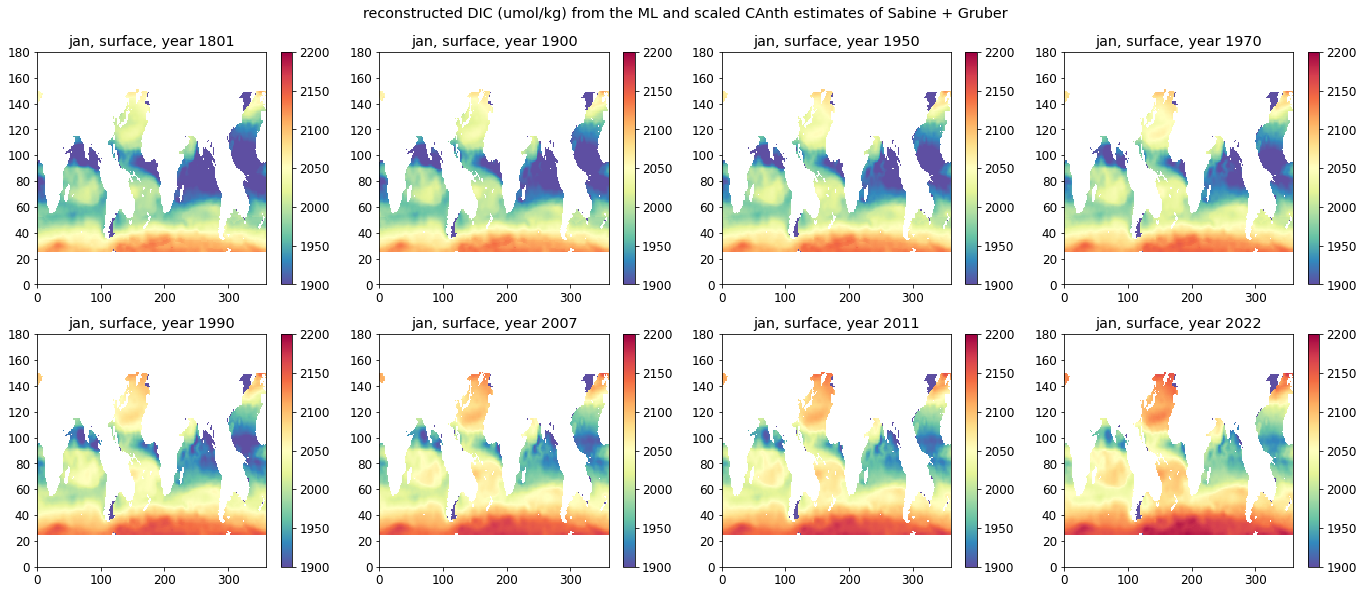

In [53]:
years = np.array([1801,1900,1950,1970,1990,2007,2011,2022])

fact = 1.2
fig, axs = plt.subplots(2,4, figsize=(16*fact, 7*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
tit = 'jan, surface'
tvmin = 1900; tvmax = 2200

for i in range(0,len(years)):
    w = xr.open_dataset(f'./WOA_AnthDIC/EstimatedDIC_{years[i]}.nc')
    q = axs[i].pcolormesh(w['Reconstructed_DIC'][0,0,:,:], vmin = tvmin, vmax = tvmax, cmap = 'Spectral_r')
    axs[i].set_title(f'{tit}, year {years[i]}')
    plt.colorbar(q, ax = axs[i])
    
fig.suptitle('reconstructed DIC (umol/kg) from the ML and scaled CAnth estimates of Sabine + Gruber')

plt.tight_layout()

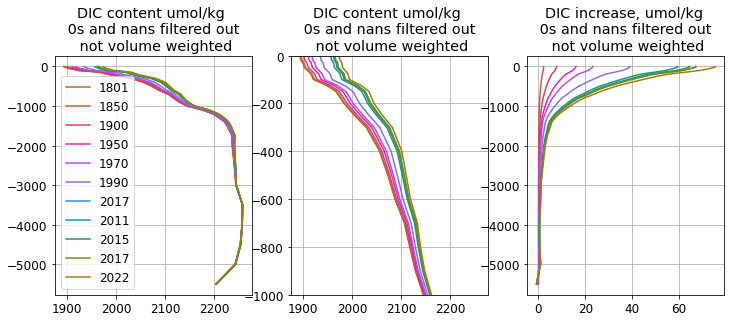

In [54]:
years = np.array([1801,1850,1900,1950,1970,1990,2017,2011,2015,2017,2022])
tcm = cm.phase

fact = 0.4
fig, axs = plt.subplots(1,3, figsize=(30*fact, 11*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,len(years)):
    w = xr.open_dataset(f'./WOA_AnthDIC/EstimatedDIC_{years[i]}.nc')

    td = w['depth']
    DIC = w['Reconstructed_DIC'].values
    DIC[DIC == 0] = np.nan
    tDIC = np.nanmean(np.nanmean(np.nanmean(DIC, axis = 0), axis = 2), axis = 1)
    axs[0].plot(tDIC,-td, color = tcm(1.*(i)/10), label = years[i])
    axs[0].legend()
    axs[0].set_title('DIC content umol/kg \n 0s and nans filtered out \n not volume weighted')
    axs[1].plot(tDIC,-td, color = tcm(1.*(i)/10), label = years[i])
    axs[1].set_ylim([-1000,0])
    axs[1].set_title('DIC content umol/kg \n 0s and nans filtered out \n not volume weighted')
    
    w = xr.open_dataset(f'./WOA_AnthDIC/AnthDIC_{years[i]}.nc')
    td = w['depth']
    DIC = w['Anth_DIC'].values
    DIC[DIC == 0] = np.nan
    tDIC = np.nanmean(np.nanmean(DIC, axis = 1), axis = 1)
    axs[2].set_title('DIC increase, umol/kg \n 0s and nans filtered out \n not volume weighted')

    axs[2].plot(tDIC,-td, color = tcm(1.*(i)/10), label = years[i])
    
for i in range(0,3):
    axs[i].grid()

Notes from CLQ:
 
    for DIC, the best DIC product would be this one here, which uses GLODAPv2 and ML for the extrapolation (this is part of the 4C project which covers Nico):
    https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0221526
    published in part here: https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020GB006571

    to estimate DIC for a previous year (t), what we have done in the past is use glodap DIC and an estimate of the anthropogenic component of DIC (DICant), and scale the anthropogenic update back using atmospheric CO2 (atmco2):

    DIC - DICant*(1-alpha)
    alpha = (atmco2(glodap)-atmco2(t))/atmco2(glodap)

    atmco2 is here: https://gml.noaa.gov/ccgg/trends/global.html

    DICant -> several products possible but best is probably the data behind https://www.science.org/doi/10.1126/science.aau5153, provided you can have the full period up to the year of GLODAPv2

    (please check the above equations make sense)

